In [1]:
import pandas as pd
import numpy as np
import urllib
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

## Data Fetching
We're sending a get request to the link to collect the data that we will be using

In [2]:
download_link = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-020-0684-z/MediaObjects/41587_2020_684_MOESM2_ESM.xlsx"
urllib.request.urlretrieve(download_link, "../data/covid_time_series.xls")

('../data/covid_time_series.xls', <http.client.HTTPMessage at 0x1a1a098278>)

## Data Cleaning/Transforming
Set types, clean column names, remove faulty formatting, discarding unused columns, and set the correct date

In [3]:
col_names = ["Date","cases_reported","model_values","forecast_values","cases_specimen","day_of_week"]
test_series = pd.read_excel("../test/testdata/dirty_series.xlsx",names=col_names)
test_series = test_series[1:].drop(["model_values","forecast_values","day_of_week"],axis=1).reset_index(drop=True).dropna() # remove the shitty data
#test_series["Date"] = pd.to_datetime(covid_series["Date"] + '-2020') # conversion to 2020 date

In [4]:
test_series.to_csv("../test/testdata/test_series.csv",index=False)

In [5]:
col_names = ["Date","cases_specimen","percent","admits","cases_reported"]
covid_series = pd.read_excel("../data/covid_time_series.xls", names=col_names)
covid_series = covid_series[5:].dropna().drop(["percent","admits"],axis=1).reset_index(drop=True) # remove the shitty data
covid_series["Date"] = pd.to_datetime(covid_series["Date"] + '-2020') # conversion to 2020 date

In [6]:
covid_series

,Date,cases_specimen,cases_reported
0,2020-03-19,10,1
1,2020-03-20,5,2
2,2020-03-21,11,1
3,2020-03-22,10,4
4,2020-03-23,25,5
...,...,...,...
69,2020-05-28,22,15
70,2020-05-29,12,25
71,2020-05-30,12,7
72,2020-05-31,5,58


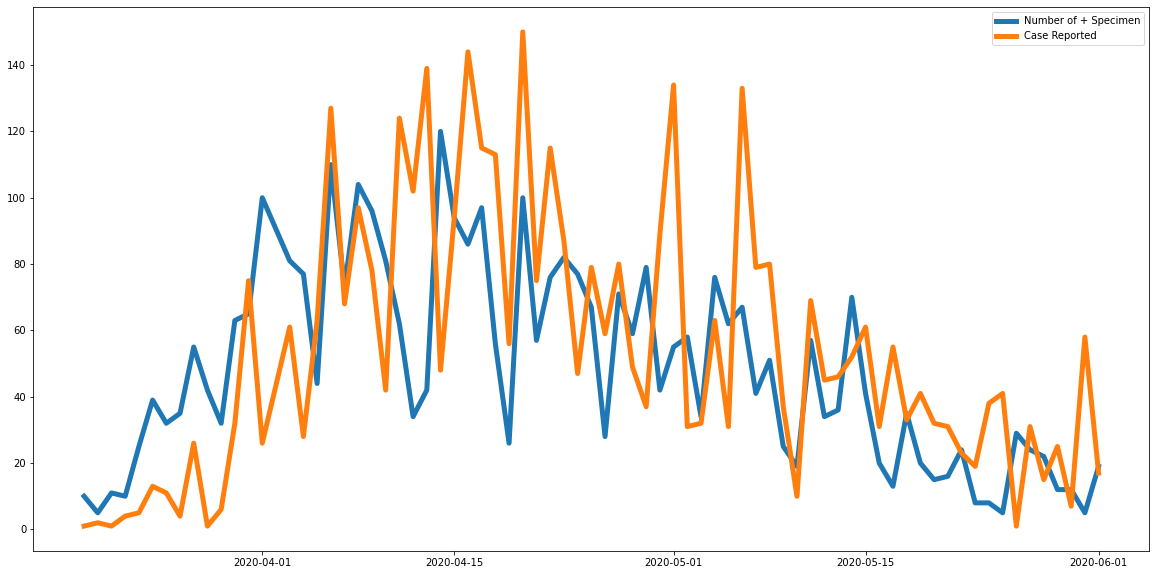

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(covid_series["Date"], covid_series["cases_specimen"], linewidth=5, label="Number of + Specimen")
plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
plt.legend()
plt.show()

## Correlation Without Offset

### Pearson

In [8]:
no_offset_r = pearsonr(covid_series["cases_reported"], covid_series["cases_specimen"])[0]

### Spearsman

In [9]:
no_offset_s = spearmanr(covid_series["cases_specimen"], covid_series["cases_reported"])[0]

In [10]:
# Baseline Loss: The lower the better the offset
1 / (no_offset_r * no_offset_s)

2.9147299893140333

## Correlation With Offset cases report -5 days

In [11]:
covid_series_neg5 = covid_series.copy()
covid_series_neg5["cases_reported"] = covid_series_neg5["cases_reported"].shift(-5)
covid_series_neg5 = covid_series_neg5.dropna()

In [12]:
len(covid_series_neg5)

69

## The I hope this works model
Based off a linear matrix transformation to find optimal offset w/ pseudo derivative (from the limit approach) of loss_ps

$$
\begin{bmatrix} 
x_1 \\
x_2 \\
\end{bmatrix} * 
\begin{bmatrix} 
m_{11} & m_{12} \\
m_{21} & m_{22} \\
\end{bmatrix}
+ 
\begin{bmatrix} 
b_1 \\
b_2 \\
\end{bmatrix}
$$

In [13]:
predictor = np.array([[x1, x2] for x1, x2 in covid_series["cases_specimen"].iteritems()])
response = np.array([[x2, x2] for x1, x2 in covid_series["cases_reported"].iteritems()])

In [14]:
def loss_p(x1, x2):
    return (1 / pearsonr(x1, x2)[0])**2
def loss_s(x1, x2):
    return (1 / spearmanr(x1, x2)[0])**2
def loss_ps(x1, x2):
    return (1 / (pearsonr(x1, x2)[0] * spearmanr(x1, x2)[0]))**2
def pseudo_deriv(h, loss_f, respect):
    """
    https://mathinsight.org/partial_derivative_limit_definition
    """
    return (loss_f(h+respect[:, 0], respect[:, 1]) - loss_f(respect[:, 0], respect[:, 1])) / h

def transform(x, M, b):
    return np.matmul(x, M) + b

# Problems: Not derivable + limit definition returns 0

In [15]:
M = np.random.random((2, 2))
b = np.random.random(2)

## I hope this works model take two
Where offset is controlled by the day (bias), also parameterized by a linear verticle transformation

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
predictor = np.array(covid_series["cases_specimen"], dtype=float).reshape(-1,1)
response = np.array(covid_series["cases_reported"], dtype=float).reshape(-1,1)

In [18]:
def MSE(x1, x2):
    return np.mean((x1-x2)**2)
def linear_reg(X, y, offset):
    X = np.append(X, np.ones((len(X), 1)), axis=1)
    return np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
def transform(X, y, offset):
    coef = linear_reg(X, y, offset)
    return X * coef[0][0] + coef[1][0]

In [19]:
transformed_X = transform(predictor, response, 0)

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(covid_series["Date"], covid_series["cases_specimen"], linewidth=5, label="Number of + Specimen")
plt.plot(covid_series.Date, transformed_X, label="Transformed")
plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
plt.legend()
plt.show()

In [20]:
loss_p(transformed_X.flatten(), response.flatten())

3.044582712121405

In [21]:
loss_p(predictor.flatten(), response.flatten())

3.0445827121214046

Turns, out pearsor isn't impacted by linear transformation 

# I'm slightly slow
Attempt three, only shift day

In [39]:
X = covid_series["cases_specimen"]
y = covid_series["cases_reported"]

In [41]:
def offset(X, y, offset, f):
    if offset >= 0:
        return f(X.shift(offset)[offset:], y[offset:])
    return f(X.shift(offset)[:offset], y[:offset])

In [42]:
for i in range(-15, 16):
    print(f"Offset: {i}. \n\tSpearman/Pearson Loss Score: {round(offset(X, y, i, loss_ps), 2)}\n\tPearson Loss Score: {round(offset(X, y, i, loss_p), 2)}\n\tSpearman Loss Score: {round(offset(X, y, i, loss_s), 2)}")

Offset: -15. 
	Spearman/Pearson Loss Score: 954.39
	Pearson Loss Score: 26.0
	Spearman Loss Score: 36.7
Offset: -14. 
	Spearman/Pearson Loss Score: 14106324.78
	Pearson Loss Score: 11032.67
	Spearman Loss Score: 1278.6
Offset: -13. 
	Spearman/Pearson Loss Score: 1923.89
	Pearson Loss Score: 49.7
	Spearman Loss Score: 38.71
Offset: -12. 
	Spearman/Pearson Loss Score: 9891.13
	Pearson Loss Score: 140.53
	Spearman Loss Score: 70.38
Offset: -11. 
	Spearman/Pearson Loss Score: 486135.38
	Pearson Loss Score: 1566.12
	Spearman Loss Score: 310.41
Offset: -10. 
	Spearman/Pearson Loss Score: 30201.31
	Pearson Loss Score: 171.05
	Spearman Loss Score: 176.57
Offset: -9. 
	Spearman/Pearson Loss Score: 7672.93
	Pearson Loss Score: 62.43
	Spearman Loss Score: 122.9
Offset: -8. 
	Spearman/Pearson Loss Score: 2917.62
	Pearson Loss Score: 50.06
	Spearman Loss Score: 58.28
Offset: -7. 
	Spearman/Pearson Loss Score: 271.8
	Pearson Loss Score: 16.88
	Spearman Loss Score: 16.1
Offset: -6. 
	Spearman/Pearson

Looks like an offset of 2, 3, and 7 days are optimal

Lowest Spearman: 3

Lowest Pearson: 2

In [25]:
offset = 2
pearsonr(X.shift(offset)[offset:], y[offset:])

(0.6317719087881046, 2.6655821736107895e-09)

In [26]:
offset = 3
spearmanr(X.shift(offset)[offset:], y[offset:])

SpearmanrResult(correlation=0.6623385361330311, pvalue=3.160708754198832e-10)

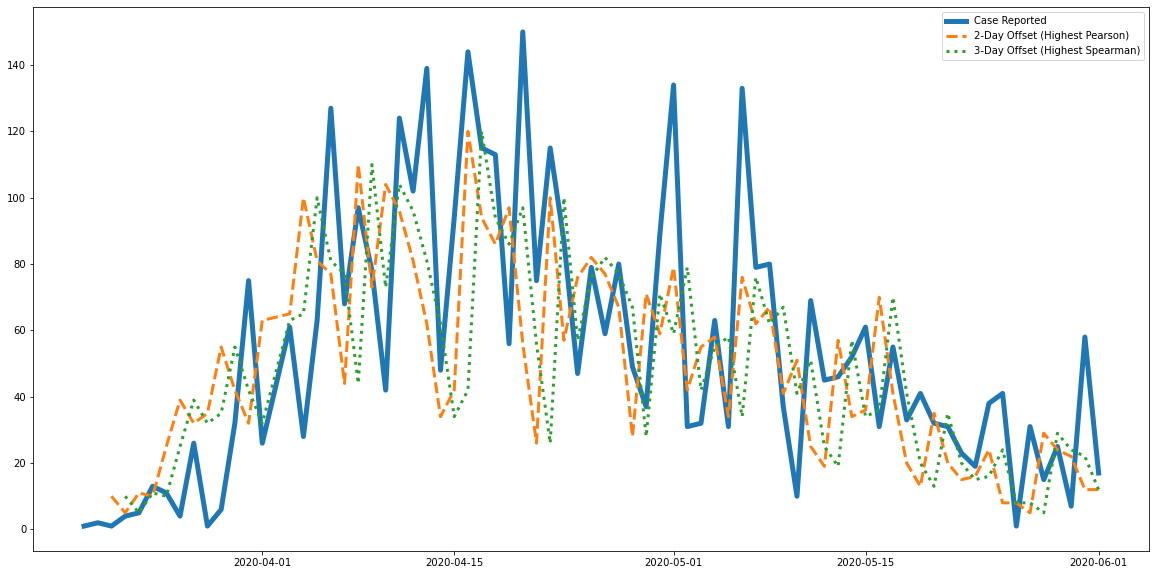

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(covid_series["Date"], covid_series["cases_specimen"], linewidth=1, label="Number of + Specimen (No Offset)")
plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(2), linestyle="--", linewidth=3, label="2-Day Offset (Highest Pearson)")
plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(3), linestyle=":", linewidth=3, label="3-Day Offset (Highest Spearman)")
plt.legend()
plt.show()

In [ ]:
def makePlot(spOffset, pOffset, sOffset):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
    plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(spOffset), linestyle="--", linewidth=3, label="Highest Spearman/Pearson Combo")
    plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(sOffset), linestyle=":", linewidth=3, label="Highest Spearman")
    plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(pOffset), linestyle=":", linewidth=3, label="Highest Pearson")

    plt.legend()
    plt.savefig("../figures/offSetPlot.png")